In [1]:
from spisea import synthetic

/home/shalmalee/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /home/shalmalee/Documents/SPISEA/spisea_cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [51]:
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt

#Parameters for building an iso

logAge = np.log10(1.7*10**9.) # Age in log(years) correct
#print(logAge)
AKs = 0.8 # extinction in mags  please check!!!!
dist = 50000 # distance in parsec .. Correct
metallicity = 0 # Metallicity in [M/H] .. need to check, might need to use parsec cmd first to get
# the values

# Define evolution/atmosphere models and extinction law
evo_model = evolution.MISTv1()  # Other models are also available

#DEfine atmo models
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()  # this is based on Hosec et al 2018b paper

#Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']
# TO DO:
# 1. USE THE HST FILTERS FOR MY CLUSTER
# 2. USE THE APPROPRIATE PARAMS FOR NGC 2173

#Make Isochrone object. Note that is calculation will take a few minutes, unless the 
# isochrone has been generated previously.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list)


9.230448921378274


In [50]:
print(my_iso.points)

          L                   Teff        ...    m_hst_f153m    
          W                    K          ...                   
---------------------- ------------------ ... ------------------
4.1202412420759625e+23 2904.3714714653606 ... 29.890932761901894
 4.483064716588099e+23  2924.254806167014 ... 29.801281045876888
 4.238323182456118e+23 2912.1689683121485 ... 29.860946203251824
 4.514167853456345e+23 2927.6692929035053 ... 29.794114979126697
4.9093409574963086e+23 2948.2762419744795 ...  29.70557739725308
  5.39445174298615e+23 2971.3640003844457 ... 29.606678182358593
 5.984398394923356e+23 2996.6919448271883 ... 29.498331211109484
 6.757865181189774e+23 3026.1578800823463 ... 29.377225587541442
 7.659070556632296e+23 3056.1817068049663 ... 29.253493468642525
  8.78458923617817e+23 3087.1162239247146 ... 29.117638679712535
                   ...                ... ...                ...
3.2167175976843104e+27    69305.793442726 ... 29.031556087875142
2.9108931994743205e+27  6

In [33]:
print(my_iso.points.meta)

OrderedDict([('REDLAW', 'H18b'), ('ATMFUNC', 'get_merged_atmosphere'), ('EVOMODEL', 'MISTv1'), ('LOGAGE', 9.230448921378274), ('AKS', 0.8), ('DISTANCE', 50000), ('METAL_IN', 0), ('METAL_ACT', 0.02380291467262473), ('WAVEMIN', 3000), ('WAVEMAX', 52000)])


In [34]:
print('The columns in the isochrone table are: {0}'.format(my_iso.points.keys()))

The columns in the isochrone table are: ['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m']


In [35]:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))


1 M_sun: F127M = 24.665 mag, F139M = 24.16 mag, F153M = 23.637 mag


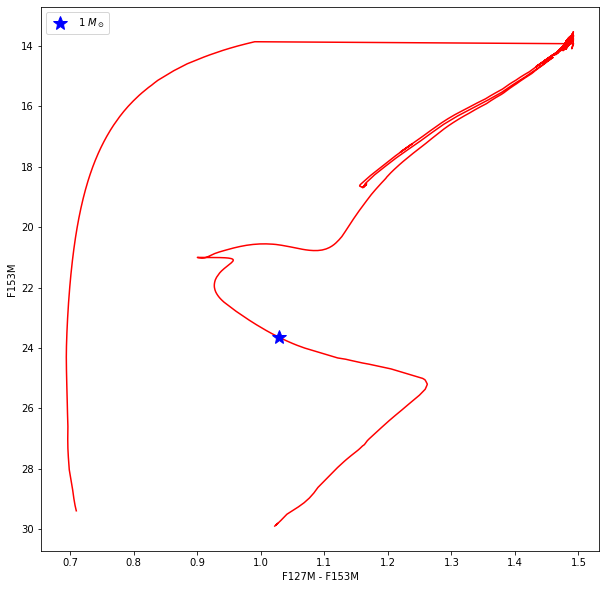

In [36]:
# Make a color-magnitude diagram
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 $M_\odot$')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

In [37]:
# Make multiplicity object
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01.

# NOTE: when defining the power law slope for each segment of the IMF, we define
# the entire exponent, including the negative sign. For example, if dN/dm $\propto$ m^-alpha,
# then you would use the value "-2.3" to specify an IMF with alpha = 2.3. 

massLimits = np.array([0.2, 0.5, 1, 120]) # Define boundaries of each mass segement
powers = np.array([-1.3, -2.3, -2.3]) # Power law slope associated with each mass segment
my_imf = imf.IMF_broken_powerlaw(massLimits, powers, imf_multi)

In [38]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

# Look at star systems table
print(cluster.star_systems)

Found 6393 stars out of mass range
        mass        isMultiple ...    m_hst_f153m     N_companions
------------------- ---------- ... ------------------ ------------
 0.9019892725613723      False ...  24.01626262466855            0
 0.3511057166482778      False ...  27.18128096551428            0
 0.2751135115350456      False ...  27.71891202983533            0
0.20114599377661171      False ...  28.38278482220688            0
 0.3553949712423165      False ...  27.13867631620277            0
 0.3104637919583903       True ... 26.836692613196227            1
 0.7103659814808393      False ...  24.84183053144994            0
0.45067212185131406       True ... 26.166418027223717            1
0.49158840811694926       True ...  26.09522187405595            1
0.38465685514352166      False ... 26.925937512978532            0
                ...        ... ...                ...          ...
0.21644515101049197      False ...  28.23108381070003            0
  0.632680385846183      Fa

In [39]:
print('The cluster table contains these columns: {0}'.format(cluster.star_systems.keys()))


The cluster table contains these columns: ['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m', 'N_companions']


No handles with labels found to put in legend.


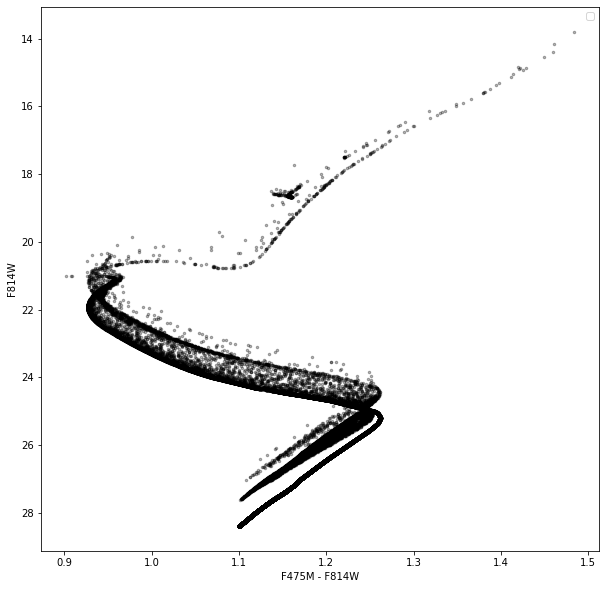

In [44]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.3, label='__nolegend__')
#py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
#       'r-', label='Isochrone')
py.xlabel('F475M - F814W')
py.ylabel('F814W')
py.gca().invert_yaxis()
py.legend()